In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import time
import pickle
import scipy

from scipy.sparse import load_npz, hstack
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFpr, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.impute import  SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm,trange
from collections import defaultdict,Counter
from text_to_num import text2num,alpha2digit

import warnings

In [16]:
def read_pkl_file(files_name):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\', file_name))
    
    name = pickle.load(open(file_paths[0], "rb"))
    ingr = pickle.load(open(file_paths[1], "rb"))
    steps = pickle.load(open(file_paths[2], "rb"))
    return name, ingr, steps

In [17]:
def model_evaluation(model, title, x,y, test_data = None):
    xtrain, xtest, ytrain, ytest = train_test_split(x,y)
    types = ['Label 1', 'Label 2', 'Label 3']#str(y.unique())

    start = time.time()
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    print(f'Model {title:s} has accuracy of: {100*accuracy_score(ypred, ytest):.2f}%, runtime {time.time()-start:3.2f} seconds')
    print(classification_report(ytest, ypred,target_names=types))
    sns.heatmap(pd.DataFrame(confusion_matrix(ytest, ypred), index=types, columns=types), annot=True, fmt='d')
    plt.title("Confusion Matrix of Model "+title)
    plt.xlabel("Predicted")
    plt.ylabel("Truth Label")
    plt.yticks(rotation=0)
    plt.show()

    if not pd.isnull(test_data):
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(x)

        xtestdata = imp.transform(test_data)
        model.fit(x,y)
        ytestdata = model.predict(xtestdata)
        out = pd.DataFrame({'duration_label':ytestdata})
        out.index += 1
        out.to_csv('output/out_'+title+'.csv',index_label = 'id')

In [21]:
curr_dir = os.path.dirname(os.path.realpath('__file__'))
train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_train.csv')
test_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_test.csv')

data_train = pd.read_csv(train_file, index_col = False, delimiter = ',')
y_train = data_train['duration_label']
data_test = pd.read_csv(test_file, index_col = False, delimiter = ',')

name, ingr, steps = read_pkl_file(['train_name_countvectorizer.pkl', 'train_ingr_countvectorizer.pkl', 'train_steps_countvectorizer.pkl'])
x_train_step = steps.fit_transform(data_train['steps'])
x_test_step = steps.transform(data_test['steps'])

x_train_ingr = ingr.fit_transform(data_train['ingredients'])
x_test_ingr = ingr.transform(data_test['ingredients'])

x_train_name = name.fit_transform(data_train['name'])
x_test_name = name.transform(data_test['name'])

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [13]:
train_data = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_train.csv').drop(['name','steps','ingredients'], axis=1)
train_data_seconds = pd.read_csv('COMP30027_2021_Project2_datasets\\input\\train_seconds.csv').drop(['name','steps','ingredients'], axis=1)
train_step_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\train_steps_doc2vec100.csv',header=None, names = ['step'+str(i) for i in range(100)])
train_ingr_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\train_ingr_doc2vec100.csv',header=None, names = ['ing'+str(i) for i in range(100)])
train_name_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\train_name_doc2vec100.csv',header=None, names = ['name'+str(i) for i in range(100)])
train_step_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\train_steps_doc2vec50.csv',header=None, names = ['step'+str(i) for i in range(50)])
train_ingr_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\train_ingr_doc2vec50.csv',header=None, names = ['ing'+str(i) for i in range(50)])
train_name_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\train_name_doc2vec50.csv',header=None, names = ['name'+str(i) for i in range(50)])

test_data = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_test.csv').drop(['name','steps','ingredients'], axis=1)
test_data_seconds = pd.read_csv('COMP30027_2021_Project2_datasets\\input\\test_seconds.csv').drop(['name','steps','ingredients'], axis=1)
test_step_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\test_steps_doc2vec100.csv',header=None, names = ['step'+str(i) for i in range(100)])
test_ingr_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\test_ingr_doc2vec100.csv',header=None, names = ['ing'+str(i) for i in range(100)])
test_name_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\test_name_doc2vec100.csv',header=None, names = ['name'+str(i) for i in range(100)])
test_step_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\test_steps_doc2vec50.csv',header=None, names = ['step'+str(i) for i in range(50)])
test_ingr_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\test_ingr_doc2vec50.csv',header=None, names = ['ing'+str(i) for i in range(50)])
test_name_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\test_name_doc2vec50.csv',header=None, names = ['name'+str(i) for i in range(50)])

Model Multinomial NB has accuracy of: 72.96%, runtime 0.02 seconds
              precision    recall  f1-score   support

     Label 1       0.72      0.73      0.73      4500
     Label 2       0.75      0.74      0.75      5023
     Label 3       0.55      0.62      0.58       477

    accuracy                           0.73     10000
   macro avg       0.68      0.70      0.69     10000
weighted avg       0.73      0.73      0.73     10000



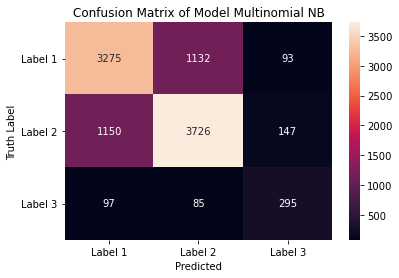

In [8]:
model_evaluation(MultinomialNB(), 'Multinomial NB', x_train_step, y_train)

Model StackingCountVecSeconds has accuracy of: 81.43%, runtime 99.88 seconds
              precision    recall  f1-score   support

     Label 1       0.80      0.81      0.81      4414
     Label 2       0.83      0.83      0.83      5105
     Label 3       0.79      0.64      0.71       481

    accuracy                           0.81     10000
   macro avg       0.81      0.76      0.78     10000
weighted avg       0.81      0.81      0.81     10000



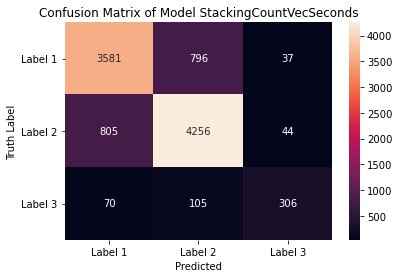

In [9]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecSeconds', Xtrain,y_train, test_data=Xtest)

Model StackingCountVec has accuracy of: 79.43%, runtime 50.28 seconds
              precision    recall  f1-score   support

     Label 1       0.79      0.78      0.78      4392
     Label 2       0.80      0.83      0.81      5097
     Label 3       0.78      0.59      0.67       511

    accuracy                           0.79     10000
   macro avg       0.79      0.73      0.76     10000
weighted avg       0.79      0.79      0.79     10000



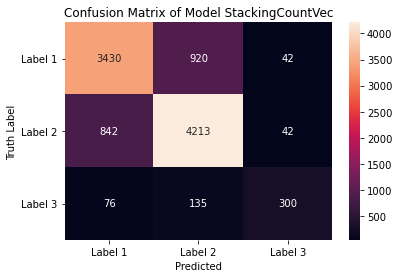

In [20]:
# Xtrain = hstack([x_train,train_data_seconds.drop('duration_label',axis=1),train_step_50])
# Xtrain.data[np.isnan(Xtrain.data)] = 0

# Xtest = hstack([x_test,test_data_seconds, test_step_50])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVec', x_train_step,y_train, test_data=x_test)

Model MultinomialNB countVec SIN has accuracy of: 72.98%, runtime 0.02 seconds
              precision    recall  f1-score   support

     Label 1       0.73      0.70      0.72      4428
     Label 2       0.74      0.77      0.76      5060
     Label 3       0.57      0.60      0.58       512

    accuracy                           0.73     10000
   macro avg       0.68      0.69      0.69     10000
weighted avg       0.73      0.73      0.73     10000



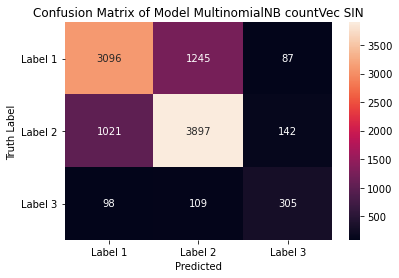

In [22]:
Xtrain = hstack([x_train_step,x_train_ingr,x_train_name])
Xtest = hstack([x_test_step,x_test_ingr,x_test_name])

model_evaluation(MultinomialNB(), 'MultinomialNB countVec SIN', Xtrain,y_train)

Model StackingCountVecStepIngrName has accuracy of: 79.39%, runtime 69.82 seconds
              precision    recall  f1-score   support

     Label 1       0.80      0.77      0.78      4499
     Label 2       0.79      0.83      0.81      4975
     Label 3       0.84      0.62      0.71       526

    accuracy                           0.79     10000
   macro avg       0.81      0.74      0.77     10000
weighted avg       0.79      0.79      0.79     10000



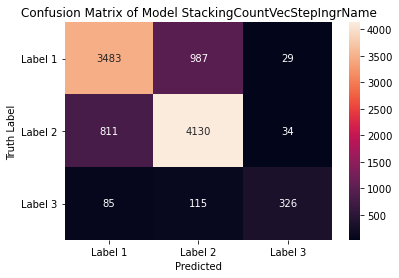

In [23]:
Xtrain = hstack([x_train_step,x_train_ingr,x_train_name])
#Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,x_test_ingr,x_test_name])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecStepIngrName', Xtrain,y_train, test_data=Xtest)

Model StackingCountVecSINSeconds has accuracy of: 81.24%, runtime 113.19 seconds
              precision    recall  f1-score   support

     Label 1       0.81      0.80      0.81      4439
     Label 2       0.81      0.84      0.83      5045
     Label 3       0.84      0.60      0.70       516

    accuracy                           0.81     10000
   macro avg       0.82      0.75      0.78     10000
weighted avg       0.81      0.81      0.81     10000



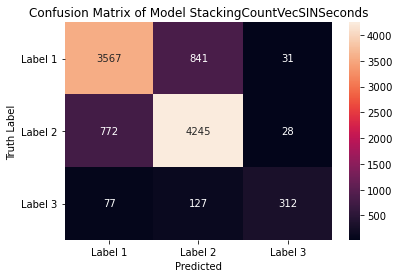

In [24]:
Xtrain = hstack([x_train_step,x_train_ingr,x_train_name,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,x_test_ingr,x_test_name,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecSINSeconds', Xtrain,y_train, test_data=Xtest)

Model StackingCountVecSISeconds has accuracy of: 81.05%, runtime 90.79 seconds
              precision    recall  f1-score   support

     Label 1       0.79      0.82      0.80      4382
     Label 2       0.82      0.83      0.83      5099
     Label 3       0.82      0.60      0.69       519

    accuracy                           0.81     10000
   macro avg       0.81      0.75      0.77     10000
weighted avg       0.81      0.81      0.81     10000



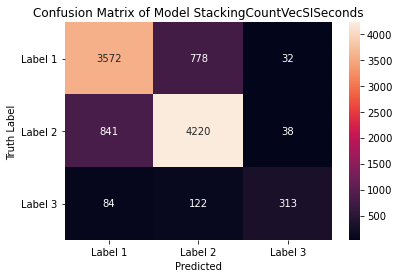

In [25]:
Xtrain = hstack([x_train_step,x_train_ingr,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,x_test_ingr,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecSISeconds', Xtrain,y_train, test_data=Xtest)

Model StackingCountVecSNSeconds has accuracy of: 80.47%, runtime 101.34 seconds
              precision    recall  f1-score   support

     Label 1       0.80      0.80      0.80      4428
     Label 2       0.81      0.83      0.82      5060
     Label 3       0.80      0.64      0.71       512

    accuracy                           0.80     10000
   macro avg       0.80      0.76      0.78     10000
weighted avg       0.80      0.80      0.80     10000



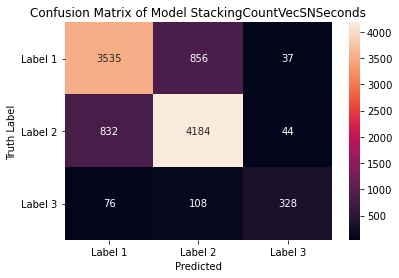

In [27]:
Xtrain = hstack([x_train_step,x_train_name,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,x_test_name,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecSNSeconds', Xtrain,y_train, test_data=Xtest)